In [1]:
import geopandas as gpd
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt
from rasterio.warp import reproject, Resampling
import numpy as np
import rasterio
import cartopy.crs as ccrs
import matplotlib.colors as mcolors
import matplotlib as mpl
import tools.config as config


def set_plot_style(font_size=12, font_family='Arial'):
    mpl.rcParams.update({
        'font.size': font_size, 'font.family': font_family,
        'axes.titlesize': font_size, 'axes.labelsize': font_size,
        'xtick.labelsize': font_size, 'ytick.labelsize': font_size,
        'legend.fontsize': font_size, 'figure.titlesize': font_size
    })


def efficient_tif_plot(
    ax,
    # ==== 栅格参数 ====
    tif_file,                 # GeoTIFF 路径
    cmap='terrain',           # 栅格颜色映射
    interpolation='nearest',  # 栅格插值方式
        
    # ==== 色条参数 ====
    title_name='',             # 图标题
    unit_name='',              # 色条单位

    # ==== 矢量参数 ====
    shp=None,                  # 矢量文件路径或 GeoDataFrame
    line_color='black',        # 矢量线颜色
    line_width=1,              # 矢量线宽
        
    # ==== 图例（色条）参数 ====
    legend_width="55%", legend_height="6%",
    legend_loc='lower left',
    legend_bbox_to_anchor=(0, 0, 1, 1),
    legend_borderpad=1,
    legend_nbins=5,
    char_ticks_length=3,  # 色条刻度标签长度
    char_ticks_pad=1,  # 色条刻度标签与色条的距离
        
    # ==== 标题位置 ====
    title_y=1,
    unit_labelpad=3
        
):
    # === 读取栅格 ===
    with rasterio.open(tif_file) as src:
        bounds = src.bounds
        data = src.read(1, masked=True)
        extent = (bounds.left, bounds.right, bounds.bottom, bounds.top)
        raster_crs = src.crs

    # 自动取 min/max 作为色带范围
    finite_vals = data.compressed() if np.ma.is_masked(data) else data[np.isfinite(data)]
    vmin, vmax = (np.min(finite_vals), np.max(finite_vals)) if finite_vals.size else (0, 1)
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

    # 栅格 CRS
    data_crs = _cartopy_crs_from_raster_crs(raster_crs)

    # 绘制栅格
    im = ax.imshow(
        data,
        origin='upper',
        extent=extent,
        transform=data_crs,
        cmap=cmap,
        norm=norm,
        interpolation=interpolation
    )

    # 绘制矢量
    if shp is not None:
        gdf = gpd.read_file(shp) if isinstance(shp, str) else shp
        gdf = gdf.to_crs(raster_crs)  # 投影到栅格 CRS
        gdf.plot(ax=ax, edgecolor=line_color, linewidth=line_width, facecolor='none')
        minx, miny, maxx, maxy = gdf.total_bounds  # (lon_min, lat_min, lon_max, lat_max)

        # 加一点 padding，防止是线要素导致高度/宽度为 0
        pad_x = (maxx - minx) * 0.02 or 1e-4
        pad_y = (maxy - miny) * 0.02 or 1e-4
        west, east = minx - pad_x, maxx + pad_x
        south, north = miny - pad_y, maxy + pad_y
        
        # 关键：用 PlateCarree，因为边界是经纬度
        ax.set_extent((west, east, south, north), crs=data_crs)


    # 设置标题
    ax.set_title(title_name, y=0.95)
    ax.set_axis_off()

    # === 色条 ===
    sm = plt.cm.ScalarMappable(norm=norm, cmap=plt.get_cmap(cmap))
    sm.set_array([])

    cax = inset_axes(
        ax,
        width=legend_width,
        height=legend_height,
        loc=legend_loc,
        borderpad=legend_borderpad,
        bbox_to_anchor=legend_bbox_to_anchor,
        bbox_transform=ax.transAxes,
    )
    cbar = plt.colorbar(
        sm, cax=cax, orientation='horizontal',
        extend='both', extendfrac=0.1, extendrect=False
    )
    cbar.outline.set_visible(False)
    cbar.ax.xaxis.set_label_position('top')
    cbar.formatter = mticker.StrMethodFormatter('{x:,.0f}')
    cbar.ax.tick_params(length=char_ticks_length, pad=char_ticks_pad)
    
    if legend_nbins == 3:
        v0, v1 = float(vmin), float(vmax)
        ticks = [v0, (v0 + v1) / 2.0, v1]
        cbar.set_ticks(ticks)
    else:
        # 自动刻度
        cbar.locator = mticker.MaxNLocator(nbins=legend_nbins)

    
    cbar.update_ticks()
    if unit_name:
        cbar.set_label(unit_name,labelpad=unit_labelpad, family='Arial')

    ax.set_title(title_name, y=title_y, fontfamily='Arial')
    return im, cbar


def _cartopy_crs_from_raster_crs(r_crs):
    """从 rasterio CRS 推断 cartopy CRS"""
    if r_crs is None:
        return ccrs.PlateCarree()
    try:
        epsg = r_crs.to_epsg()
        if epsg:
            return ccrs.epsg(epsg)
    except Exception:
        pass
    if getattr(r_crs, 'is_geographic', False):
        return ccrs.PlateCarree()
    return ccrs.PlateCarree()



def align_raster_to_reference(src_path, ref_path, dst_path,
                              resampling="nearest", dtype=None, nodata=None, compress="deflate"):
    """
    将 src_path 的栅格重投影/重采样对齐到 ref_path 的网格，保存到 dst_path。
    - 分辨率、宽高、transform、CRS 与参考一致
    - 适合掩膜层(0/1)：resampling='nearest'
    - 适合连续值：resampling='bilinear' 或 'cubic'
    """
    # 选择重采样算法
    resampling_map = {
        "nearest": Resampling.nearest,
        "bilinear": Resampling.bilinear,
        "cubic": Resampling.cubic
    }
    rs = resampling_map.get(resampling, Resampling.nearest)

    # 打开参考栅格
    with rasterio.open(ref_path) as ref:
        ref_profile = ref.profile.copy()
        dst_crs = ref.crs
        dst_transform = ref.transform
        dst_width = ref.width
        dst_height = ref.height
        # 参考 nodata
        ref_nodata = ref.nodata

    # 打开源栅格
    with rasterio.open(src_path) as src:
        src_data = src.read(1)  # 单波段情况
        src_crs = src.crs
        src_transform = src.transform
        src_nodata = src.nodata

    # 目标 dtype / nodata 处理
    if dtype is None:
        dtype = src_data.dtype
    if nodata is None:
        # 对掩膜层：缺省 nodata = 0（或你可改成 255 视你的数据而定）
        nodata = src_nodata if src_nodata is not None else 0

    # 准备输出数组
    dst_data = np.full((dst_height, dst_width), nodata, dtype=dtype)

    # 重投影+重采样到参考网格
    reproject(
        source=src_data,
        destination=dst_data,
        src_transform=src_transform,
        src_crs=src_crs,
        src_nodata=src_nodata,
        dst_transform=dst_transform,
        dst_crs=dst_crs,
        dst_nodata=nodata,
        resampling=rs,
    )

    # 写出
    profile_out = ref_profile.copy()
    profile_out.update(dtype=dtype, nodata=nodata, compress=compress, count=1)

    with rasterio.open(dst_path, "w", **profile_out) as dst:
        dst.write(dst_data, 1)

    return dst_path



def _crs_for_cartopy(rio_crs):
    """尽量把 rasterio 的 CRS 转成 cartopy 的 CRS。"""
    if rio_crs is None:
        return ccrs.PlateCarree(), False
    try:
        epsg = rio_crs.to_epsg()
        if epsg:
            return ccrs.epsg(epsg), True
    except Exception:
        pass
    # 尝试用字符串（WKT/PROJ4）创建——部分 cartopy 版本不支持所有字符串
    try:
        return ccrs.CRS.from_user_input(rio_crs.to_string()), True
    except Exception:
        return ccrs.PlateCarree(), False

def add_binary_gray_layer(ax, tif_file, gray_hex="#808080", alpha=0.6, zorder=10, debug=False):
    """
    将 tif 中 ==1 的像元画成灰色(可调透明度)，其它(0或NoData)透明。
    """
    with rasterio.open(tif_file) as src:
        band = src.read(1, masked=True)   # MaskedArray（nodata 已遮蔽为 mask=True）
        bounds = src.bounds
        rio_crs = src.crs

    # 1) 只把“未被掩膜 & 等于 1”的像元标为 1
    mask01 = np.zeros(band.shape, dtype=np.uint8)
    valid = ~band.mask
    mask01[valid & (band == 1)] = 1

    if debug:
        unique, counts = np.unique(mask01, return_counts=True)
        print("mask01 counts:", dict(zip(unique.tolist(), counts.tolist())))

    # 若全是 0，自然什么都看不到
    if mask01.sum() == 0 and debug:
        print("No pixels equal to 1 after masking; nothing to draw from this layer.")

    # 2) 颜色映射：0 -> 透明，1 -> 灰色(带透明度)
    rgba = list(mcolors.to_rgba(gray_hex))
    rgba[3] = alpha
    cmap = mcolors.ListedColormap([(0, 0, 0, 0), tuple(rgba)])

    # 3) CRS / 范围
    data_crs, ok = _crs_for_cartopy(rio_crs)
    if not ok and debug:
        print("Warning: raster CRS not recognized by cartopy; falling back to PlateCarree().")

    extent = (bounds.left, bounds.right, bounds.bottom, bounds.top)

    # 4) 画
    im = ax.imshow(
        mask01,
        origin="upper",
        extent=extent,
        transform=data_crs,   # 让 cartopy 负责坐标变换
        cmap=cmap,
        interpolation="nearest",
        vmin=0, vmax=1,       # 固定 0/1 映射
        zorder=zorder
    )
    return im



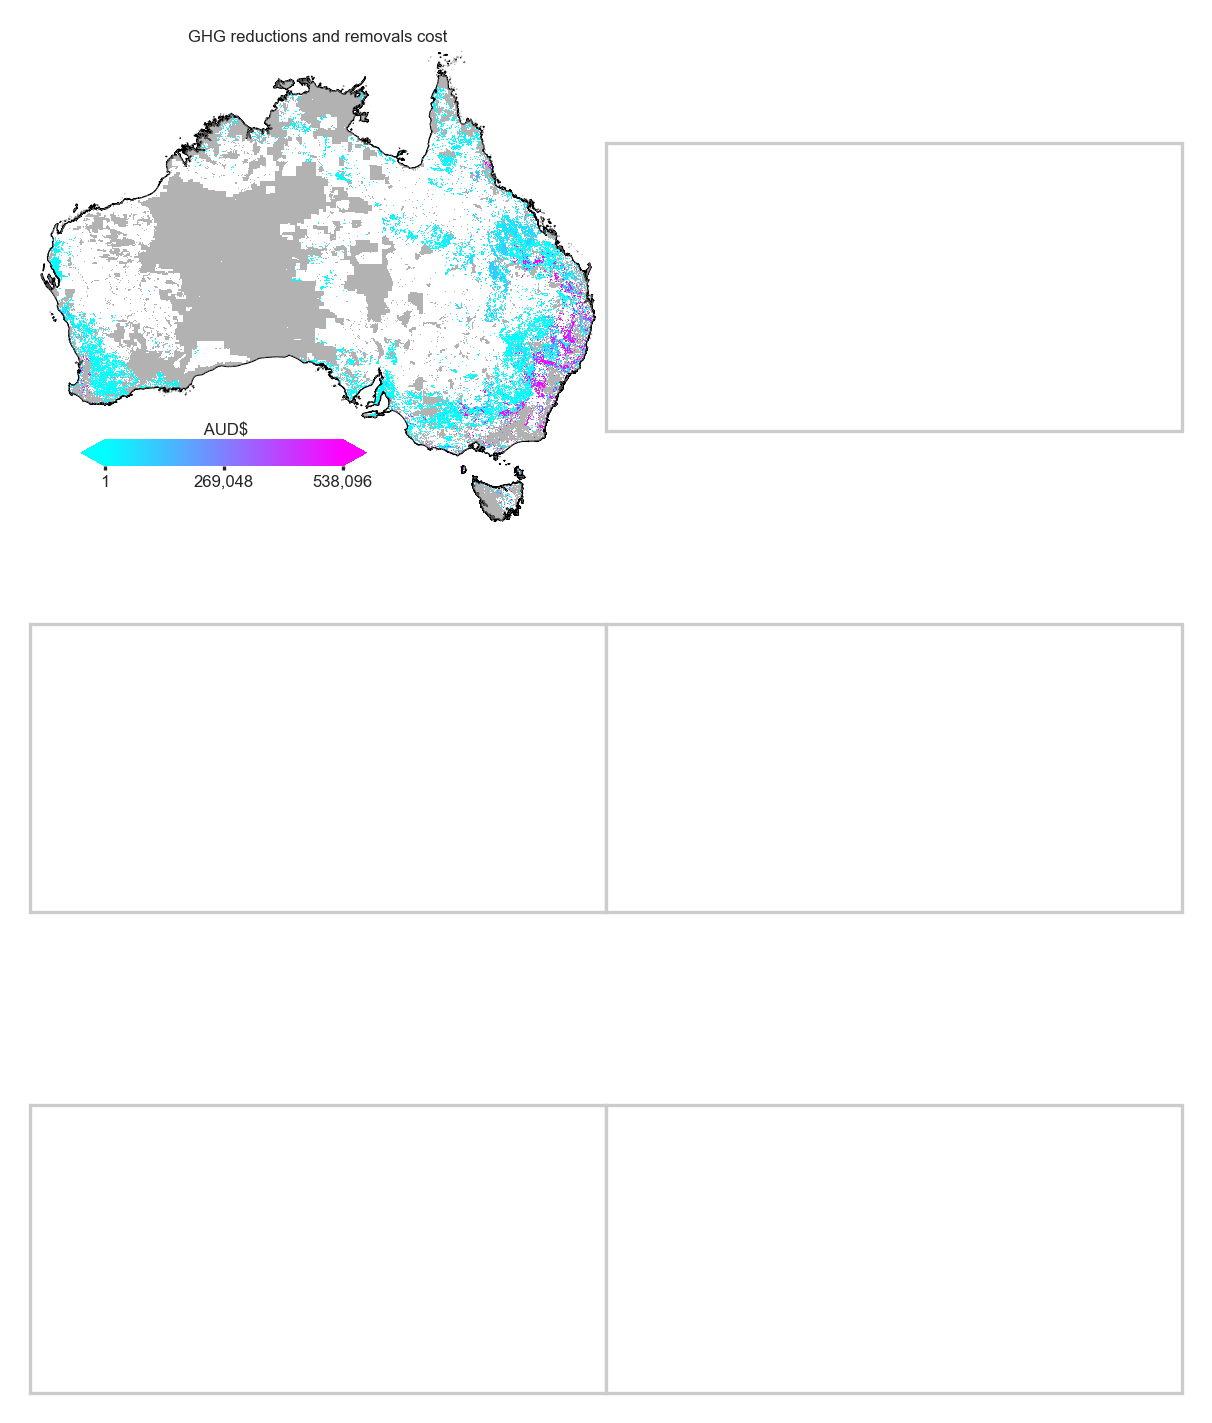

In [2]:
arr_path = f"{config.TASK_DIR}/carbon_price/map_data"
ref_tif = f'{arr_path}/ghg_2050.tif'
src_tif = f'{arr_path}/public_area.tif'
aligned_tif = f'{arr_path}/public_area_aligned_to_ghg_2050.tif'

set_plot_style(font_size=4, font_family='Arial')
# 掩膜层用最近邻
align_raster_to_reference(src_tif, ref_tif, aligned_tif, resampling="nearest")

# 画图（两者像元网格完全一致了）
fig, axes = plt.subplots(3,2,subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(4,6), dpi=300,constrained_layout=False)
axes = axes.flatten()

fields = {
    0: ("carbon_cost_2050.tif", "GHG reductions and removals cost", " AUD$", "cool"),
    # 1: ("bio_cost_2050.tif","Biodiversity restoration cost", "AUD$", "cool"),
    # 2: ("ghg_2050.tif","GHG reductions and removals", "tCO2e", "summer_r"),
    # 3: ("bio_2050.tif","Biodiversity restoration", "ha", "summer_r"),
    # 4: ("carbon_price_2050.tif","Shadow carbon price", r"$\mathrm{AUD}\$\,\mathrm{CO}_{2}\,\mathrm{e}^{-1}$", "winter_r"),
    # 5: ("bio_price_2050.tif","Shadow biodiversity price", r"$\mathrm{AUD}\$\,\mathrm{ha}^{-1}$", "winter_r")
}

for i, (tif_file, title, unit, cmap) in fields.items():
    efficient_tif_plot(
        axes[i], f"{arr_path}/{tif_file}", cmap=cmap,
        shp="../Map/AU_boundary_line_main.shp", line_width=0.3,
        title_name=title, unit_name=unit,
        legend_bbox_to_anchor=(0.06, 0.10, 0.9, 0.9), legend_nbins=3,title_y=0.95,char_ticks_length=1, unit_labelpad=1
    )
    add_binary_gray_layer(axes[i], aligned_tif, gray_hex="#808080", alpha=0.6, zorder=15)


plt.subplots_adjust(left=0.02, right=0.98, top=0.99, bottom=0.01, wspace=0, hspace=-0.4)
# 保存图像
# plt.savefig(f"{config.TASK_DIR}/carbon_price/Paper_figure/map_test.png", dpi=300, bbox_inches=None)
# plt.show()


In [3]:
import matplotlib.patches as patches
from matplotlib.lines import Line2D

def _get_overlay_ax(fig):
    # 复用已存在的覆盖轴，避免重复创建
    for a in fig.axes:
        if getattr(a, "_overlay_for_annotations", False):
            return a
    ax = fig.add_axes([0, 0, 1, 1], frameon=False, zorder=1000)
    ax._overlay_for_annotations = True
    ax.set_axis_off()
    ax.set_facecolor('none')          # 透明，关键！
    ax.patch.set_alpha(0.0)
    return ax

def add_annotation(fig, x, y, width=None, height=None, text="",
                   style="box",
                   facecolor='white', edgecolor=None,
                   linecolor='black', linewidth=1.0,
                   textcolor='black', fontsize=8, fontfamily='Arial'):
    """
    在整张图(fig坐标 0~1)上加 方框/线 + 文字，不影响子图。
    (0,0) 左下，(1,1) 右上；x,y 是方框左下或线段起点。
    """
    overlay = _get_overlay_ax(fig)              # 透明覆盖轴
    trans = overlay.transAxes                   # 等效于 fig.transFigure

    if style == "box":
        rect = patches.Rectangle(
            (x, y), width, height,
            facecolor=facecolor,
            edgecolor=('none' if edgecolor is None else edgecolor),
            transform=trans, zorder=1001
        )
        overlay.add_patch(rect)
        overlay.text(x + width/2, y + height/2, text,
                     color=textcolor, fontsize=fontsize, fontfamily=fontfamily,
                     ha='center', va='center', transform=trans, zorder=1002)

    elif style == "line":
        line = Line2D([x, x + width], [y, y],
                      color=linecolor, linewidth=linewidth,
                      transform=trans, zorder=1001)
        overlay.add_line(line)
        overlay.text(x + width + 0.005, y, text,
                     color=textcolor, fontsize=fontsize, fontfamily=fontfamily,
                     ha='left', va='center', transform=trans, zorder=1002)


In [4]:
add_annotation(fig, 0.02, 0.20, width=0.01, text="National line",
               style="line", linecolor="black")
add_annotation(fig, 0.02, 0.20, width=0.02, height=0.02, text="Invalid value",
               style="box", facecolor="white", edgecolor="black")
add_annotation(fig, 0.02, 0.60, width=0.02, height=0.02, text="Public, indigenous, urban, and other intensive land uses",
               style="box", facecolor="#808080")  # 不传 edgecolor 就没边框

plt.savefig(f"{config.TASK_DIR}/carbon_price/Paper_figure/map_test_annotated.png", dpi=300, bbox_inches=None)
plt.show()

<Figure size 640x480 with 0 Axes>

In [5]:
!pip install matplotlib-scalebar cartopy

In [1]:
!pip install matplotlib-map-utils


  Using cached matplotlib_map_utils-3.1.0-py3-none-any.whl.metadata (21 kB)
Using cached matplotlib_map_utils-3.1.0-py3-none-any.whl (93 kB)


In [2]:
!pip install matplotlib